# Raw Data Processing - Road Stock in Norway 

This code represents the master thesis of the studednt Leo Liberkowski

## Preparation: Packages and data imports

We start by importing the necessary packages:

In [1]:
# Write all the necessary imports here
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from regression_functions import *
from dynamic_stock_model import *
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from pathlib import Path
from matplotlib.patches import Rectangle

In [2]:
personnal_path = Path.cwd().parents[1]
print(personnal_path)


c:\leo\double-diplome\COURSES\year 2\Master thesis\code\master_thesis


Then we import the different data into a Dataframe using the pandas read_excel function and we clean it.

## Data import

### Road Description

In [21]:
# Extracting data from the source file into a panda Dataframe
file = personnal_path / "data" / "01.Raw" / "Road_description" / "road_description.xlsx"

headers = pd.read_excel(file, sheet_name=0, header=None, skiprows=0, nrows=1, usecols="A:F").iloc[0]
data_road_description = pd.read_excel(
    file,
    sheet_name=0,
    header=0,
    usecols="A:F",
    index_col=[0, 1],
    engine="openpyxl",
)

data_road_description.iloc[0:10, 0:5]




European & National Highways (Type 1)  Country Road (Type 2)  \
1935 length (m)                                 8344.0                    0.0   
     width (m)                                     7.0                    0.0   
     length (m)                                    0.0                    0.0   
     width (m)                                     0.0                    0.0   
     length (m)                                    0.0                    0.0   
     width (m)                                     0.0                    0.0   
1942 length (m)                                    0.0                 1826.0   
     width (m)                                     0.0                    9.0   
     length (m)                                 5955.0                    0.0   
     width (m)                                     6.0                    0.0   

                 Municipale Roads (Type3)  Gravel Roads (Type4)  
1935 length (m)                       0.0                   0.0  
     width (m)                        0.0                   0.0  
     length (m)                    7115.0                   0.0  
     width (m)                        9.0                   0.0  
     length (m)                       0.0                9998.0  
     width (m)                        0.0                  10.0  
1942 length (m)                       0.0                   0.0  
     width (m)                        0.0                   0.0  
     length (m)                       0.0                   0.0  
     width (m)                        0.0                   0.0

We want to focus on the percentage of each type of road type in order to calculate the stock/inflow/outflow of road  per type from 1935 to 2050. Therefore, we have to see if we consider a constant coefficient, or if we try to do a regrerssion on the percentage. Let's now draw the repartition of each type of road from 1935 to 2026.

In [22]:
idx = data_road_description.index
# Create boolean masks to identify length and width rows
is_length = idx.get_level_values(1).astype(str).str.contains("length", case=False, na=False)
is_width  = idx.get_level_values(1).astype(str).str.contains("width",  case=False, na=False)

lengths = data_road_description[is_length].copy()
widths  = data_road_description[is_width].copy()

# Add a counter within each year
# This ensures that the first length matches the first width,
# the second length matches the second width, etc.
lengths["_pair"] = lengths.groupby(level=0).cumcount()
widths["_pair"]  = widths.groupby(level=0).cumcount()

# Set (year, pair_id) as index to align matching rows
lengths = lengths.reset_index(level=1, drop=True).set_index("_pair", append=True)
widths  = widths.reset_index(level=1, drop=True).set_index("_pair", append=True)

# Keep only the type columns (remove helper column if needed)
type_cols = [c for c in data_road_description.columns if c != "_pair"]
lengths = lengths[type_cols]
widths  = widths[type_cols]

# Compute area per pair (length × width)
areas_per_pair = lengths.mul(widths)

# Sum all pairs within each year
areas_per_year = areas_per_pair.groupby(level=0).sum()

# Create a new column for the total area
areas_per_year['Total Area'] = areas_per_year.sum(axis=1)

print(areas_per_year)

      European & National Highways (Type 1)  Country Road (Type 2)  \
1935                                58408.0                    0.0   
1942                                35730.0                16434.0   
1951                                69789.0                21792.0   
1959                                    0.0                    0.0   
1968                                98098.0                48296.0   
1974                                79407.0               162542.0   
1981                                    0.0               122347.0   
1985                               197781.0               118404.0   
1989                                    0.0               256455.0   
1994                               174024.0               130160.0   
1998                                    0.0               192593.0   
2001                               240008.0               154601.0   
2005                               439330.0               363187.0   
2008                

In [23]:
for col in areas_per_year.columns:
    if col != "Total Area":
        areas_per_year[f"{col} (%)"] = (
            areas_per_year[col] / areas_per_year["Total Area"]
        ) * 100

In [24]:
areas_per_year

,European & National Highways (Type 1),Country Road (Type 2),Municipale Roads (Type3),Gravel Roads (Type4),Total Area,European & National Highways (Type 1) (%),Country Road (Type 2) (%),Municipale Roads (Type3) (%),Gravel Roads (Type4) (%)
1935,58408.0,0.0,64035.0,99980.0,222423.0,26.259874,0.000000,28.789738,44.950387
1942,35730.0,16434.0,0.0,1038.0,53202.0,67.159129,30.889816,0.000000,1.951054
1951,69789.0,21792.0,8406.0,0.0,99987.0,69.798074,21.794833,8.407093,0.000000
1959,0.0,0.0,27992.0,124584.0,152576.0,0.000000,0.000000,18.346267,81.653733
1968,98098.0,48296.0,52415.0,0.0,198809.0,49.342837,24.292663,26.364501,0.000000
1974,79407.0,162542.0,0.0,0.0,241949.0,32.819726,67.180274,0.000000,0.000000
1981,0.0,122347.0,132775.0,22710.0,277832.0,0.000000,44.036324,47.789671,8.174004
1985,197781.0,118404.0,0.0,0.0,316185.0,62.552303,37.447697,0.000000,0.000000
1989,0.0,256455.0,61110.0,0.0,317565.0,0.000000,80.756695,19.243305,0.000000
1994,174024.0,130160.0,0.0,123196.0,427380.0,40.718798,30.455332,0.000000,28.825869


Let's look at the graphs of these figures:

<Figure size 640x480 with 0 Axes>

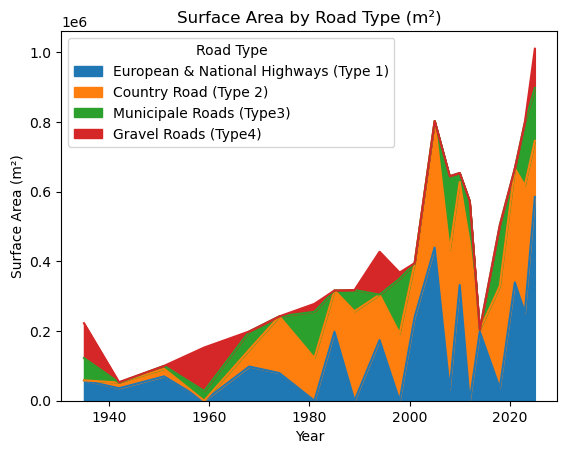

In [26]:
area_cols = ["European & National Highways (Type 1)", "Country Road (Type 2)", "Municipale Roads (Type3)", "Gravel Roads (Type4)"]

plt.figure()

areas_per_year[area_cols].plot(kind="area")

plt.title("Surface Area by Road Type (m²)")
plt.xlabel("Year")
plt.ylabel("Surface Area (m²)")
plt.legend(title="Road Type")

plt.show()

<Figure size 640x480 with 0 Axes>

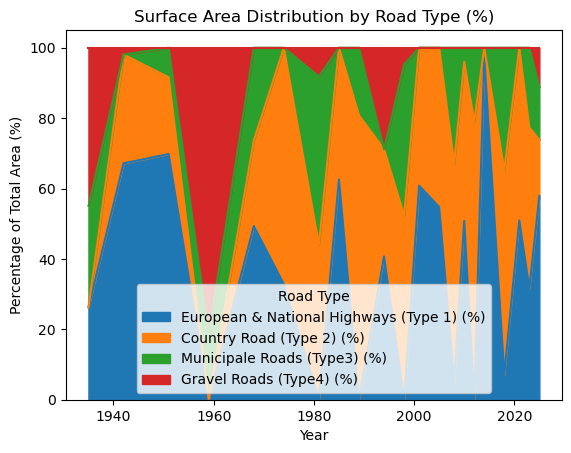

In [27]:
percent_cols = ["European & National Highways (Type 1) (%)", "Country Road (Type 2) (%)", "Municipale Roads (Type3) (%)", "Gravel Roads (Type4) (%)"]

plt.figure()

areas_per_year[percent_cols].plot(kind="area")

plt.title("Surface Area Distribution by Road Type (%)")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Area (%)")
plt.legend(title="Road Type")

plt.show()

### Road Composition

We import the road composition table:

In [28]:
# Extracting data from the source file into a panda Dataframe
file = personnal_path / "data" / "01.Raw" / "Road_composition" / "road_composition.xlsx"

data_road_composition = pd.read_excel(
    file,
    sheet_name=0,
    header=[0, 1],   # rows 1-2 as a two-level column header
    index_col=0,     # column A as index
    engine="openpyxl"
)

# Keep only rows corresponding to Excel rows 3..8
# (because rows 1-2 are headers, first data row is already "Excel row 3")
data_road_composition = data_road_composition.iloc[0:6]

# Keep only columns B..P (i.e. remove column A which is index, keep next 15 cols)
data_road_composition = data_road_composition.iloc[:, 0:15]

data_road_composition

European & National Highways (Type 1)                \
                                              Surface course Binder course   
SMA/dense asphalt                                          4             0   
Gravel                                                     0             0   
Asphalt concrete                                           0             7   
Asphalt base                                               0             0   
Crush rock                                                 0             0   
Compacted natural soil                                     0             0   

                                                                       \
                       Base course Sub-base/Frost protection Subgrade   
SMA/dense asphalt                0                         0        0   
Gravel                           0                         0        0   
Asphalt concrete                 0                         0        0   
Asphalt base                    20                         0        0   
Crush rock                       0                       100        0   
Compacted natural soil           0                         0       20   

                       Country Road (Type 2)              \
                              Surface course Base course   
SMA/dense asphalt                          0           0   
Gravel                                     0           0   
Asphalt concrete                           4           0   
Asphalt base                               0          20   
Crush rock                                 0           0   
Compacted natural soil                     0           0   

                                                           \
                       Sub-base/Frost protection Subgrade   
SMA/dense asphalt                              0        0   
Gravel                                         0        0   
Asphalt concrete                               0        0   
Asphalt base                                   0        0   
Crush rock                                    80        0   
Compacted natural soil                         0       20   

                       Municipale Roads (Type3)                            \
                                 Surface course Binder course Base course   
SMA/dense asphalt                             0             0           0   
Gravel                                        0             0           0   
Asphalt concrete                              4             8           0   
Asphalt base                                  0             0           0   
Crush rock                                    0             0          20   
Compacted natural soil                        0             0           0   

                                                 Gravel Roads (Type4)  \
                       Sub-base/Frost protection        Wearing Layer   
SMA/dense asphalt                              0                    0   
Gravel                                         0                   10   
Asphalt concrete                               0                    0   
Asphalt base                                   0                    0   
Crush rock                                    60                    0   
Compacted natural soil                         0                    0   

                                   
                       Base layer  
SMA/dense asphalt               0  
Gravel                          0  
Asphalt concrete                0  
Asphalt base                    0  
Crush rock                     30  
Compacted natural soil          0

Let's plot a graph to have an idea on the different layers:

In [29]:
def build_road_layers(df: pd.DataFrame):
    # Road types in the order they appear in the file
    road_types_in_order = pd.Index(df.columns.get_level_values(0)).drop_duplicates().tolist()

    road_layers = {}
    tidy_rows = []

    for road_type in road_types_in_order:
        # slice: columns for this road type, keeps layer order
        df_type = df.loc[:, road_type]

        layers = []
        for layer_name in df_type.columns:
            # non-zero materials for this layer
            nz = df_type[layer_name]
            nz = nz[nz != 0]

            for material, thickness in nz.items():
                rec = {
                    "road_type": road_type,
                    "layer": layer_name,
                    "material": material,
                    "thickness": float(thickness),
                }
                layers.append(rec)
                tidy_rows.append(rec)

        road_layers[road_type] = layers

    tidy_df = pd.DataFrame(tidy_rows, columns=["road_type", "layer", "material", "thickness"])
    return road_layers, tidy_df


road_layers, road_layers_df = build_road_layers(data_road_composition)



In [30]:
road_layers_df

,road_type,layer,material,thickness
0,European & National Highways (Type 1),Surface course,SMA/dense asphalt,4.0
1,European & National Highways (Type 1),Binder course,Asphalt concrete,7.0
2,European & National Highways (Type 1),Base course,Asphalt base,20.0
3,European & National Highways (Type 1),Sub-base/Frost protection,Crush rock,100.0
4,European & National Highways (Type 1),Subgrade,Compacted natural soil,20.0
5,Country Road (Type 2),Surface course,Asphalt concrete,4.0
6,Country Road (Type 2),Base course,Asphalt base,20.0
7,Country Road (Type 2),Sub-base/Frost protection,Crush rock,80.0
8,Country Road (Type 2),Subgrade,Compacted natural soil,20.0
9,Municipale Roads (Type3),Surface course,Asphalt concrete,4.0


In [31]:
def plot_road_section(
    road_layers_df,
    road_type,
    layer_order=None,
    width=4,
    min_height_inside=12,     # cm : en-dessous, on déporte le texte
    fontsize_inside=9,
    fontsize_outside=9,
    outside_x_pad=0.6,        # décalage horizontal des labels externes
    outside_y_min_gap=6       # gap vertical mini entre labels externes (cm)
):
    df = road_layers_df[road_layers_df["road_type"] == road_type].copy()
    if df.empty:
        raise ValueError(f"No layers found for road_type='{road_type}'")

    # ordre des couches
    if layer_order is None:
        layer_order = df["layer"].drop_duplicates().tolist()

    df["layer"] = pd.Categorical(df["layer"], categories=layer_order, ordered=True)
    df = df.sort_values(["layer"])

    # couleurs par matériau
    materials = df["material"].unique().tolist()
    cmap = plt.get_cmap("tab20")
    material_to_color = {m: cmap(i % cmap.N) for i, m in enumerate(materials)}

    total_thickness = float(df["thickness"].sum())
    y = 0.0

    fig, ax = plt.subplots(figsize=(8, 6))

    # Pour éviter que les labels externes se chevauchent
    used_outside_y = []

    for layer_name in layer_order:
        chunk = df[df["layer"] == layer_name]
        if chunk.empty:
            continue

        for _, row in chunk.iterrows():
            t = float(row["thickness"])
            mat = row["material"]
            color = material_to_color[mat]

            # rectangle
            rect = Rectangle((0, y), width, t, facecolor=color, edgecolor="black", linewidth=1)
            ax.add_patch(rect)

            yc = y + t / 2  # centre vertical de la couche

            label_inside = f"{layer_name}\n{mat}\n{t:g}"
            label_outside = f"{layer_name} — {mat} ({t:g} cm)"

            if t >= min_height_inside:
                # Texte au centre (couches épaisses)
                ax.text(
                    width / 2, yc,
                    label_inside,
                    ha="center", va="center",
                    fontsize=fontsize_inside
                )
            else:
                # Texte à droite + flèche (couches fines)
                y_label = yc
                # Décaler si trop proche d'un label déjà posé
                for prev in used_outside_y:
                    if abs(y_label - prev) < outside_y_min_gap:
                        y_label = prev + outside_y_min_gap
                used_outside_y.append(y_label)

                ax.annotate(
                    label_outside,
                    xy=(width, yc), xycoords="data",
                    xytext=(width + outside_x_pad, y_label), textcoords="data",
                    ha="left", va="center",
                    fontsize=fontsize_outside,
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.85),
                    arrowprops=dict(arrowstyle="-", lw=1),
                    clip_on=False
                )

            y += t

    ax.set_xlim(-0.5, width + 5)  # plus large à droite pour les callouts
    ax.set_ylim(0, max(total_thickness * 1.05, 1))
    ax.set_xticks([])
    ax.set_ylabel("Thickness (cm)")
    ax.set_title(road_type)
    ax.set_aspect("auto")
    plt.show()

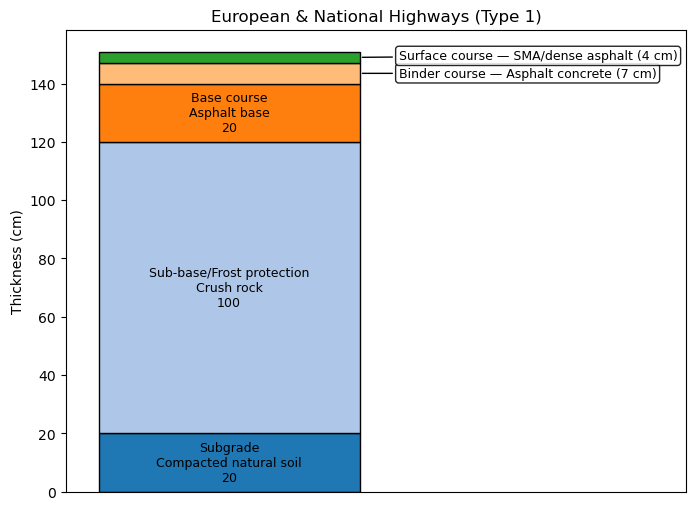

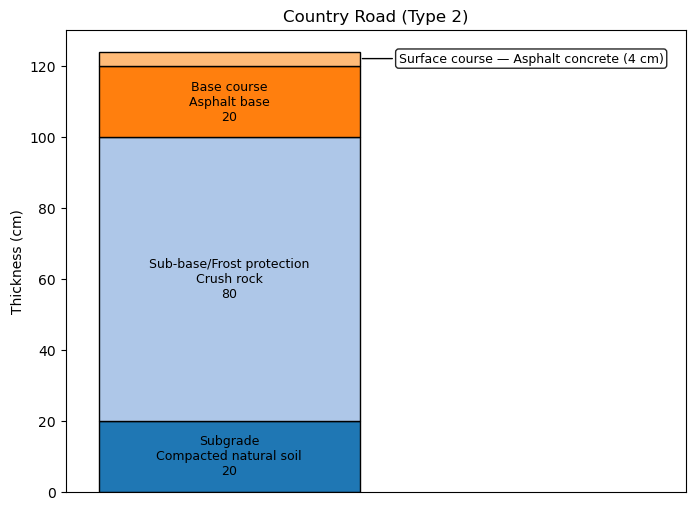

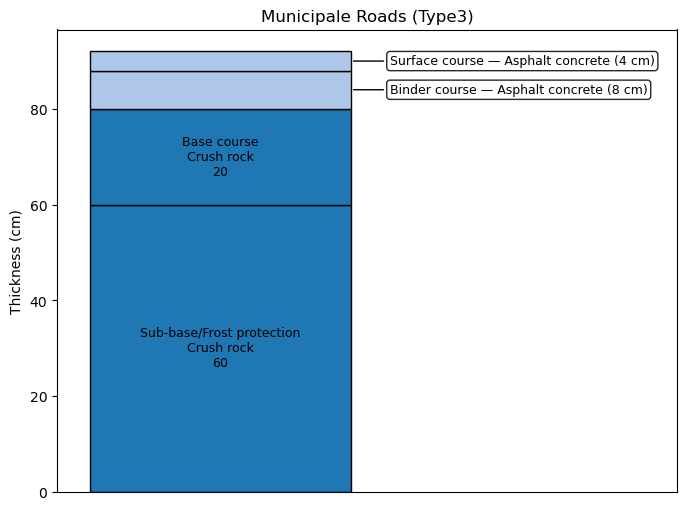

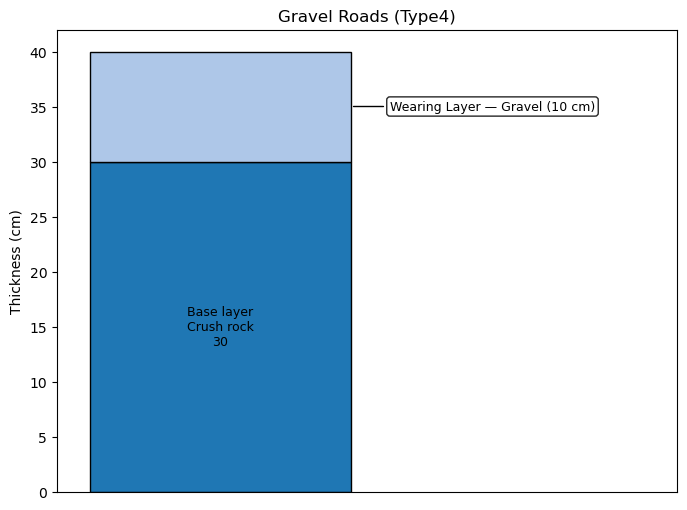

In [32]:
plot_road_section(
    road_layers_df,
    "European & National Highways (Type 1)",
    layer_order=["Subgrade", "Sub-base/Frost protection", "Base course", "Binder course", "Surface course"],
    min_height_inside=12
)

plot_road_section(
    road_layers_df,
    "Country Road (Type 2)",
    layer_order=["Subgrade", "Sub-base/Frost protection", "Base course", "Surface course"],
    min_height_inside=12
)

plot_road_section(
    road_layers_df,
    "Municipale Roads (Type3)",
    layer_order=["Sub-base/Frost protection", "Base course", "Binder course", "Surface course"],
    min_height_inside=12
)

plot_road_section(
    road_layers_df,
    "Gravel Roads (Type4)",
    layer_order=["Base layer", "Wearing Layer"],
    min_height_inside=12
)


### Material intensity

We import the data:

In [33]:
# Extracting data from the source file into a panda Dataframe
file_MI = personnal_path / "data" / "01.Raw" / "Material_intensities" / "material_intensity.xlsx"

data_material_intensity = pd.read_excel(
    file_MI,
    sheet_name=0,
    header=0,
    usecols="A:B",
    index_col=[0],
    engine="openpyxl",
)


### Calculation of the material need throughout the years and the environmental impact

In [43]:
data_road_composition

European & National Highways (Type 1)                \
                                              Surface course Binder course   
SMA/dense asphalt                                          4             0   
Gravel                                                     0             0   
Asphalt concrete                                           0             7   
Asphalt base                                               0             0   
Crush rock                                                 0             0   
Compacted natural soil                                     0             0   

                                                                       \
                       Base course Sub-base/Frost protection Subgrade   
SMA/dense asphalt                0                         0        0   
Gravel                           0                         0        0   
Asphalt concrete                 0                         0        0   
Asphalt base                    20                         0        0   
Crush rock                       0                       100        0   
Compacted natural soil           0                         0       20   

                       Country Road (Type 2)              \
                              Surface course Base course   
SMA/dense asphalt                          0           0   
Gravel                                     0           0   
Asphalt concrete                           4           0   
Asphalt base                               0          20   
Crush rock                                 0           0   
Compacted natural soil                     0           0   

                                                           \
                       Sub-base/Frost protection Subgrade   
SMA/dense asphalt                              0        0   
Gravel                                         0        0   
Asphalt concrete                               0        0   
Asphalt base                                   0        0   
Crush rock                                    80        0   
Compacted natural soil                         0       20   

                       Municipale Roads (Type3)                            \
                                 Surface course Binder course Base course   
SMA/dense asphalt                             0             0           0   
Gravel                                        0             0           0   
Asphalt concrete                              4             8           0   
Asphalt base                                  0             0           0   
Crush rock                                    0             0          20   
Compacted natural soil                        0             0           0   

                                                 Gravel Roads (Type4)  \
                       Sub-base/Frost protection        Wearing Layer   
SMA/dense asphalt                              0                    0   
Gravel                                         0                   10   
Asphalt concrete                               0                    0   
Asphalt base                                   0                    0   
Crush rock                                    60                    0   
Compacted natural soil                         0                    0   

                                   
                       Base layer  
SMA/dense asphalt               0  
Gravel                          0  
Asphalt concrete                0  
Asphalt base                    0  
Crush rock                     30  
Compacted natural soil          0

In [49]:
data_road= areas_per_year.iloc[:,0:4]
data_road

,European & National Highways (Type 1),Country Road (Type 2),Municipale Roads (Type3),Gravel Roads (Type4)
1935,58408.0,0.0,64035.0,99980.0
1942,35730.0,16434.0,0.0,1038.0
1951,69789.0,21792.0,8406.0,0.0
1959,0.0,0.0,27992.0,124584.0
1968,98098.0,48296.0,52415.0,0.0
1974,79407.0,162542.0,0.0,0.0
1981,0.0,122347.0,132775.0,22710.0
1985,197781.0,118404.0,0.0,0.0
1989,0.0,256455.0,61110.0,0.0
1994,174024.0,130160.0,0.0,123196.0


In [50]:
data_road_composition_sum = data_road_composition.groupby(level=0, axis=1, sort=False).sum()

C:\Users\leoli\AppData\Local\Temp\ipykernel_3048\3912282272.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_road_composition_sum = data_road_composition.groupby(level=0, axis=1, sort=False).sum()


In [54]:
material_per_year = data_road @ data_road_composition_sum.transpose()
material_per_year

,SMA/dense asphalt,Gravel,Asphalt concrete,Asphalt base,Crush rock,Compacted natural soil
1935,233632.0,999800.0,1177276.0,1168160.0,13963000.0,1168160.0
1942,142920.0,10380.0,315846.0,1043280.0,4918860.0,1043280.0
1951,279156.0,0.0,676563.0,1831620.0,9394740.0,1831620.0
1959,0.0,1245840.0,335904.0,0.0,5976880.0,0.0
1968,392392.0,0.0,1508850.0,2927880.0,17866680.0,2927880.0
1974,317628.0,0.0,1206017.0,4838980.0,20944060.0,4838980.0
1981,0.0,227100.0,2082688.0,2446940.0,21091060.0,2446940.0
1985,791124.0,0.0,1858083.0,6323700.0,29250420.0,6323700.0
1989,0.0,0.0,1759140.0,5129100.0,25405200.0,5129100.0
1994,696096.0,1231960.0,1738808.0,6083680.0,31511080.0,6083680.0


<Figure size 1000x600 with 0 Axes>

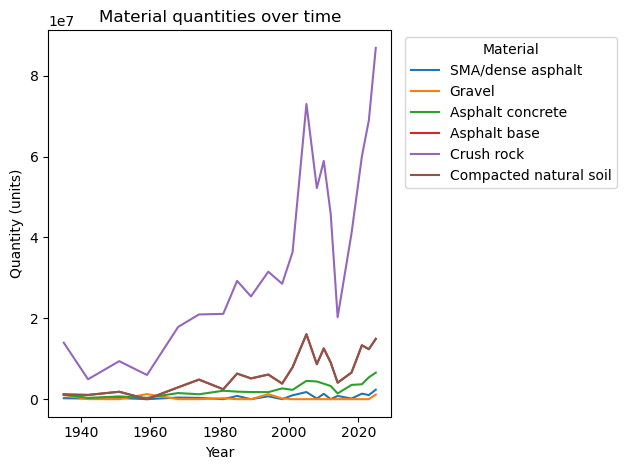

In [ ]:
plt.figure(figsize=(10, 6))
material_per_year.plot()
plt.title("Material quantities over time")
plt.xlabel("Year")
plt.ylabel("Quantity (units)")
plt.legend(title="Material", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [56]:
emissions = material_per_year @ data_material_intensity
emissions

,CO2 (kg/m3)
1935,4.529386e+08
1942,2.186402e+08
1951,4.108125e+08
1959,1.150274e+08
1968,7.270412e+08
1974,9.033235e+08
1981,7.131462e+08
1985,1.298938e+09
1989,9.883170e+08
1994,1.280903e+09


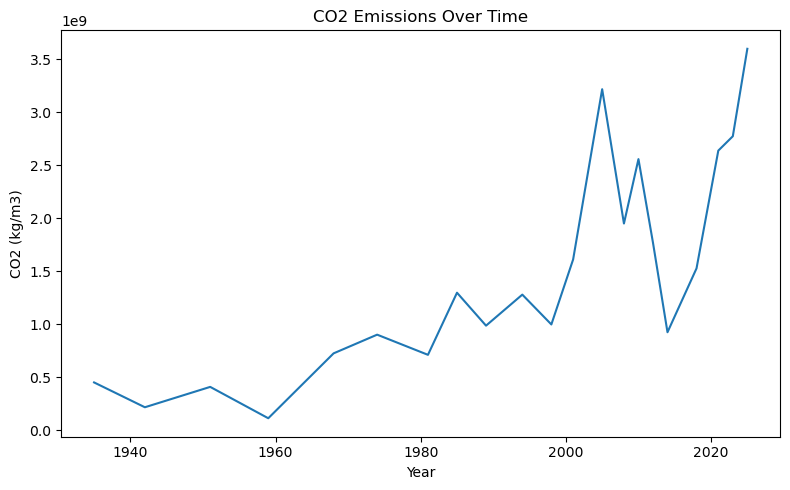

In [57]:
plt.figure(figsize=(8,5))

plt.plot(emissions.index, emissions["CO2 (kg/m3)"])

plt.title("CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 (kg/m3)")

plt.tight_layout()
plt.show()

## Regression from 1935 to 2050 for the different data sets

The aim is now to obtain the stock, the inputs and the outputs for every year from 1600 to 2050.

For this period, we will use the following method to obtain the stock/input/output.  
1) We will compute a regression on the population, the people per dwelling and on the percentage of repartition of the types of dwelling.  
2) Then, we will obtain the stock thanks to these values with the relation: $stock= \frac{population}{ppd}$
3) Finally, we will use a stock-driven model in order to obtain the input, output and stock change


First, let's create a dataframe to stock our regressions:

In [23]:
years = list(range(1600,2051))
years=np.array(years)
# Créer un DataFrame avec une colonne 'construction year class'
years_pd = pd.DataFrame(years, columns=['construction year class'])

### Population

We will now focus on the population, and we will calculate the regression from 1600 to 2050.

In [24]:
#Dataset
label_courbes=['Polynomial degree 1', 'Polynomial degree 2', 'Polynomial degree 3', 'Logistic', 'Natural cubic spline']

#We add a new row to have a limit condition in 1600 and we assume that the population is 0
new_row = {'Year': 1600, 'Central': 0, 'Fécondité basse': 0, 'Fécondité haute': 0, 'Espérance de vie basse': 0, 'Espérance de vie haute': 0, 'Solde migratoire bas': 0, 'Solde migratoire haut': 0, 'Population basse': 0, 'Population haute': 0}
new_row_df = pd.DataFrame([new_row])
data_pop_new = pd.concat([new_row_df,data_pop], ignore_index=True)

#we create a new list to stock the future regression values
regression_finale_pop=[years,[],[],[],[],[]]


#### Polynomial regression

In [25]:
columns_to_process=[1,2,3,4,5,6,7,8,9]
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp,poly_out=polynomial_deg123_reg(reg_years, reg_values, years)
    regression_finale_pop[1].append(poly_out[0])
    regression_finale_pop[2].append(poly_out[1])
    regression_finale_pop[3].append(poly_out[2])


 the polynomial our fit created is: 
 
1.844e+05 x - 3.105e+08.
 the polynomial our fit created is: 
       2
310.6 x - 1.004e+06 x + 8.253e+08.
 the polynomial our fit created is: 
       3             2
2.039 x - 1.104e+04 x + 2e+07 x - 1.208e+10.
 the polynomial our fit created is: 
 
1.818e+05 x - 3.055e+08.
 the polynomial our fit created is: 
       2
293.8 x - 9.428e+05 x + 7.689e+08.
 the polynomial our fit created is: 
       3             2
1.886 x - 1.021e+04 x + 1.849e+07 x - 1.117e+10.
 the polynomial our fit created is: 
 
1.869e+05 x - 3.152e+08.
 the polynomial our fit created is: 
       2
326.7 x - 1.064e+06 x + 8.796e+08.
 the polynomial our fit created is: 
       3             2
2.186 x - 1.184e+04 x + 2.145e+07 x - 1.295e+10.
 the polynomial our fit created is: 
 
1.825e+05 x - 3.068e+08.
 the polynomial our fit created is: 
       2
298.1 x - 9.587e+05 x + 7.835e+08.
 the polynomial our fit created is: 
       3             2
1.927 x - 1.043e+04 x + 1.889e+07 x -

#### Logistic Regression

In [26]:
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=logistic_reg(reg_years, reg_values, years, 'black', 0, 0, 1000000000, 10, 80000000)
    regression_finale_pop[4].append(poly_out)
  

The optimal choice of parameters for the logistic function, given the sample data, is [1.90581364e+03 9.44858965e+01 9.99999306e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90558387e+03 9.59674729e+01 9.99999955e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90603078e+03 9.31034694e+01 9.99998970e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90564485e+03 9.55889922e+01 9.99999239e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90598955e+03 9.33383677e+01 9.99998240e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90553598e+03 9.63337647e+01 9.99999171e+00 8.00000000e+07] (ti, tau, C0, C1)

#### Cubic regression

In [27]:
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=natural_cubic_line_reg(reg_years, reg_values, years, 'black')
    regression_finale_pop[5].append(poly_out)


The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model


#### Comparison of the regressions

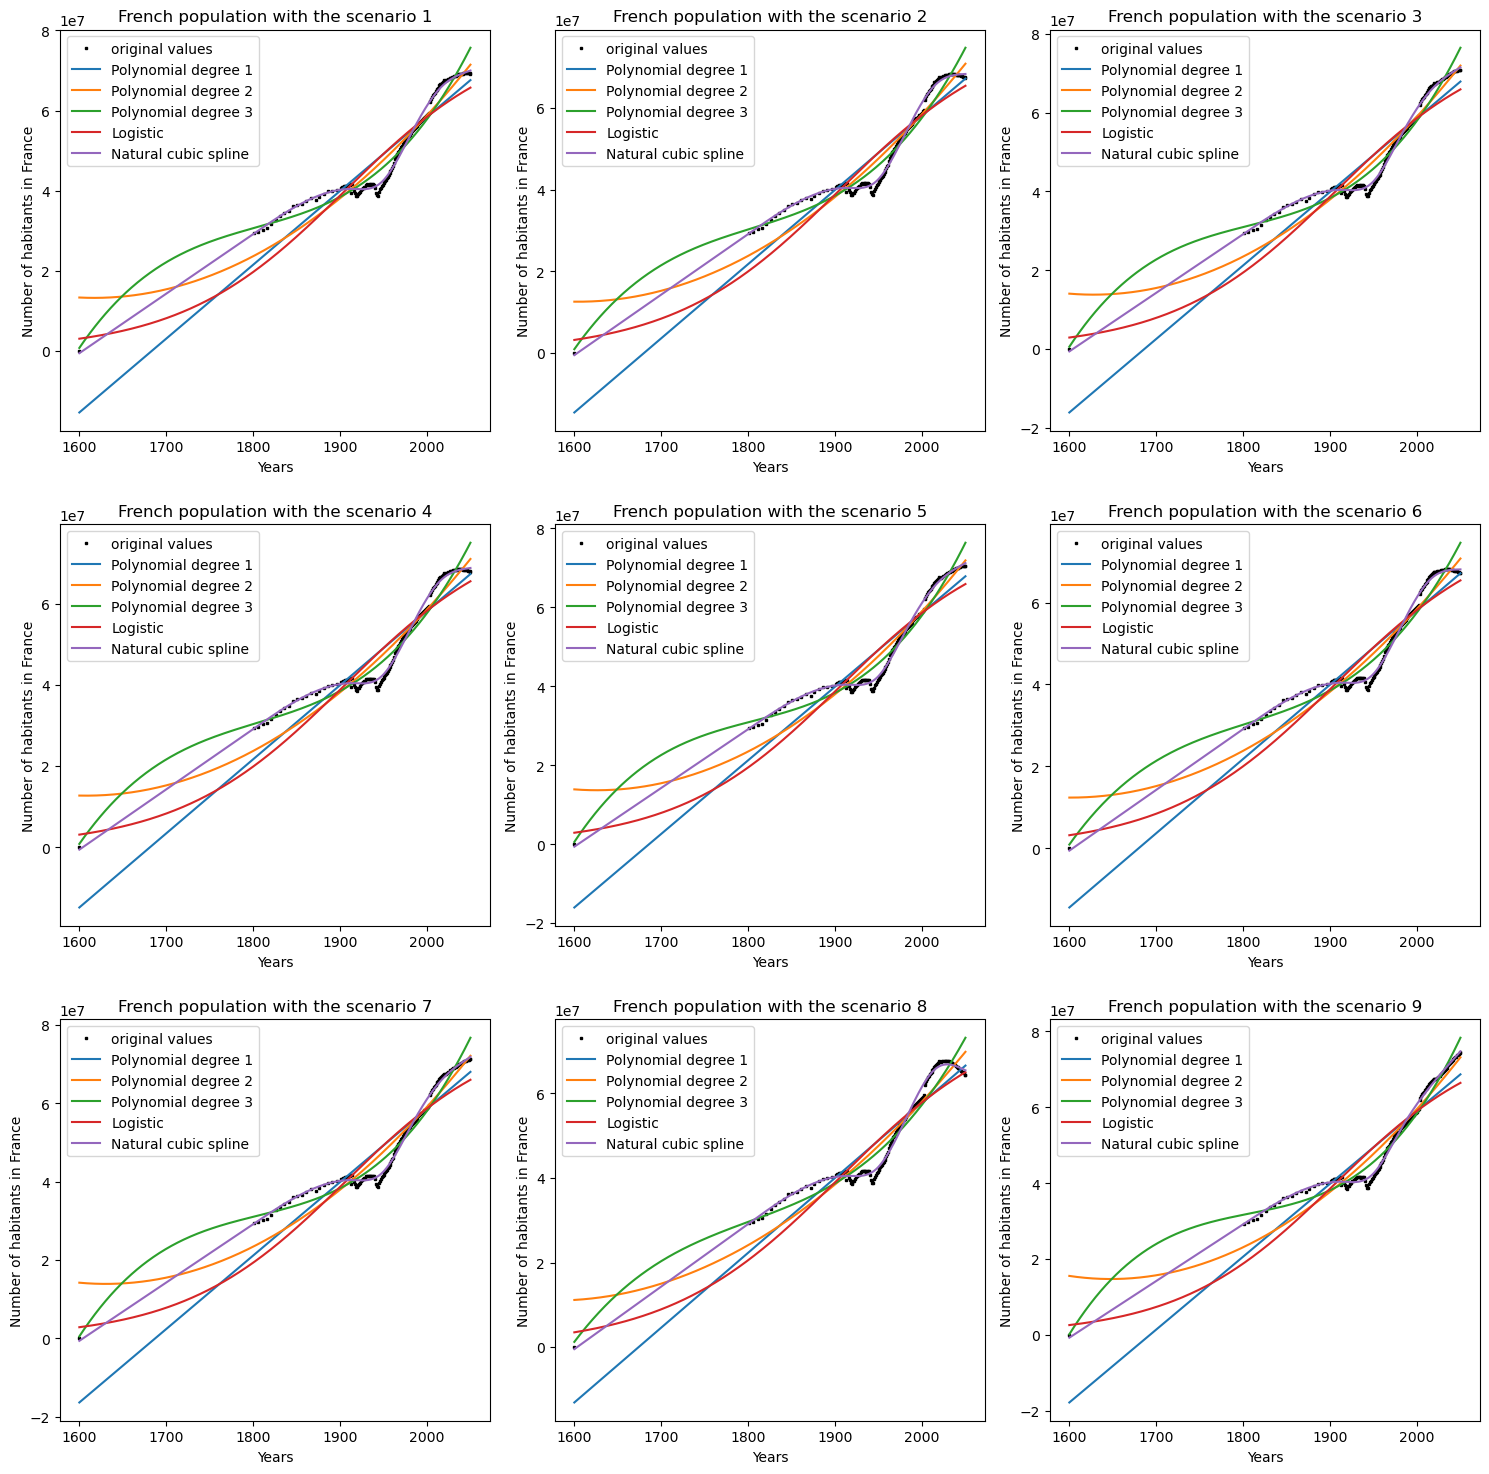

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Itérer sur les colonnes et les axes pour tracer les graphiques
for col, ax in enumerate(axes.flatten()):
    ax.plot(reg_years, data_pop_new.iloc[:, col+1], 's', color='black', markersize=2, label='original values')
    for i in range(1, 6):
        x_values = regression_finale_pop[0]
        y_values = regression_finale_pop[i][col]
        ax.plot(x_values, y_values, label=label_courbes[i-1])
    ax.set_xlabel('Years')
    ax.set_ylabel(f'Number of habitants in France')
    ax.set_title(f'French population with the scenario {col+1}')
    ax.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

We will use the natural cubic spline for our regression method.

### PpD

#### Preparation of the Data

In [29]:
label_courbes=['Polynomial degree 1', 'Polynomial degree 2', 'Polynomial degree 3', 'Logistic', 'Natural cubic spline']
# Supprimez les lignes avec des valeurs manquantes
data_PpD = data_PpD.dropna(subset=[data_PpD.columns[0], data_PpD.columns[1]])
new_row = {'Year': 1600, 'PpD': 4}
new_row_df = pd.DataFrame([new_row])
data_PpD_new = pd.concat([new_row_df,data_PpD], ignore_index=True)

#ajout de n lignes pour la regression encessitant 10 valeurs
n=2
for i in range(n):
    new_row_bis = {'Year': round((data_PpD_new.iloc[0,0]+data_PpD_new.iloc[1,0])/2), 'PpD': (data_PpD_new.iloc[0,1]+data_PpD_new.iloc[1,1])/2}
    new_row_bis_df = pd.DataFrame([new_row_bis])
    data_PpD_new = pd.concat([data_PpD_new.iloc[:1], new_row_bis_df, data_PpD_new.iloc[1:]], ignore_index=True)


# Transformer les colonnes spécifiques en tableaux numpy

regression_finale_PpD=[years,[],[],[],[],[]]

#### Polynomial Regression

In [34]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp,poly_out=polynomial_deg123_reg(reg_years, reg_values, years)
    regression_finale_PpD[1].append(poly_out[0])
    regression_finale_PpD[2].append(poly_out[1])
    regression_finale_PpD[3].append(poly_out[2])


 the polynomial our fit created is: 
 
-0.004211 x + 10.92.
 the polynomial our fit created is: 
            2
-1.429e-05 x + 0.04804 x - 36.44.
 the polynomial our fit created is: 
            3             2
-1.043e-07 x + 0.0005524 x - 0.9749 x + 576.8.


#### Logistic regression

In [35]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=logistic_reg(reg_years, reg_values, years, 'black', 0, 0, 1000000, 1000000, 1000000)
    regression_finale_PpD[4].append(poly_out)


The optimal choice of parameters for the logistic function, given the sample data, is [1.97517660e+03 2.17326117e+01 3.77470313e+00 1.96673326e+00] (ti, tau, C0, C1).


#### Cubic Regression

In [36]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    print(reg_years)
    print(reg_values)
    poly_inp, poly_out=natural_cubic_line_reg(reg_years, reg_values, years, 'black')
    regression_finale_PpD[5].append(poly_out)


[1600. 1690. 1781. 1962. 1968. 1975. 1982. 1990. 1999. 2008. 2013. 2018.
 2019. 2020.]
[4.    3.775 3.55  3.1   3.06  2.89  2.71  2.58  2.4   2.3   2.24  2.19
 2.18  2.17 ]
The ncs_model


c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
 

#### Comparison of the regressions 

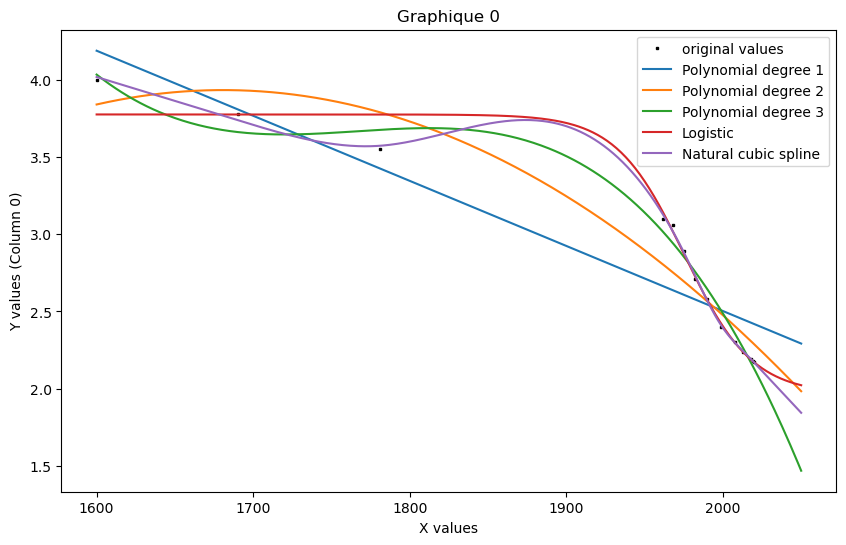

In [38]:
for col in range(1):
    plt.figure(figsize=(10, 6))
    plt.plot(reg_years, data_PpD_new.iloc[:,col+1], 's', color = 'black', markersize = 2, label = f'original values')
    for i in range(1,6):
        x_values = regression_finale_PpD[0]
        y_values = regression_finale_PpD[i][col]
        plt.plot(x_values, y_values, label=label_courbes[i-1])
    plt.xlabel('X values')
    plt.ylabel(f'Y values (Column {col})')
    plt.title(f'Graphique {col}')
    plt.legend()
    plt.show()

We finally choose the regression natural cubic spline

## Baseline scenario

We have now data sets from 1600 to 2050 for the population, the people per dwelling and the repartition of the different types of dwelling.
We will now stock these data sets in a DataFrame and calculate our baseline scenario to help us for our scenarios.
 

### Stock-driven model from 1600 to 2050

In [44]:
# create a new dataframe to stock the final data
data_final= pd.DataFrame(columns=['Year', 'Population', 'Inflow', 'Outflow', 'Stock Change', 'Stock', 'PpD'])
data_final['Year']=years
data_final['Population']=regression_finale_pop[-1][0] #we choose the cubic spline regression (with the [-1]) and the central scenario (with the [0])
data_final['PpD']=regression_finale_PpD[-1][0] #we choose the cubic spline regression (with the [-1])
# replace negative value in population and people per dwelling by 0
data_final.loc[data_final['Population'] < 0, 'Population'] = 0
data_final['Stock']=data_final['Population']/data_final['PpD']
data_final.fillna(0, inplace=True)
display(data_final)


C:\Users\Clothilde\AppData\Local\Temp\ipykernel_18532\3129730137.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_final.fillna(0, inplace=True)


,Year,Population,Inflow,Outflow,Stock Change,Stock,PpD
0,1600,0.000000e+00,0,0,0,0.000000e+00,4.017039
1,1601,0.000000e+00,0,0,0,0.000000e+00,4.013938
2,1602,0.000000e+00,0,0,0,0.000000e+00,4.010837
3,1603,0.000000e+00,0,0,0,0.000000e+00,4.007736
4,1604,3.135472e+03,0,0,0,7.829607e+02,4.004635
...,...,...,...,...,...,...,...
446,2046,6.967725e+07,0,0,0,3.691195e+07,1.887661
447,2047,6.975382e+07,0,0,0,3.716569e+07,1.876834
448,2048,6.982985e+07,0,0,0,3.742208e+07,1.866006
449,2049,6.990560e+07,0,0,0,3.768132e+07,1.855179


We now compute the stock driven model method in order to find the inflows, the outflows and the stock change.

In [45]:
#calculation of the outflow/inflows/stock change
a = (40 - 80) / 20
b = (200- 80) / 20
Stock= data_final.loc[:,'Stock'].to_numpy()
TestDSMX = DynamicStockModel(t = np.arange(1600,2051,1), s = Stock, lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([80]), 'StdDev': np.array([20]) })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_C_sd, O_C_sd, I_sd, ExitFlag = TestDSMX.compute_stock_driven_model()
O_sd, ExitFlag   = TestDSMX.compute_outflow_total()
DS_sd, ExitFlag  = TestDSMX.compute_stock_change()
Bal_sd, ExitFlag = TestDSMX.check_stock_balance()
#print(TestDSMX.s_c)

#print(type(O_sd))
data_final.loc[:,'Outflow']=  O_sd[:]
data_final.loc[:,'Inflow']=  I_sd[:] 
data_final.loc[:,'Stock Change']=  DS_sd[:]
print(data_final.head())

stock_2011=data_final.loc[data_final['Year']==2011]['Stock']

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow is not present.<br>Total stock is present with 451 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

C:\Users\Clothilde\AppData\Local\Temp\ipykernel_18532\329853508.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.27371290e+00 1.10459902e+02 2.29883720e+02
 3.61367310e+02 5.05751985e+02 6.63893562e+02 8.36657085e+02
 1.02491098e+03 1.

### Inflow-driven model for each dwelling types

In [46]:
data_typesplit_percentage = pd.read_excel(personnal_path + 'Project-TEP4290\\data\\02.Processed_baseline\\buildings\\type_split\\data_percentage.xlsx', header = 0, index_col = 0)
data_typesplit_percentage.reset_index(drop=True, inplace=True)

data_final['Inflow SFH'] = data_final['Inflow'] * data_typesplit_percentage['SFH (%)'] * 0.01
data_final['Inflow TH'] = data_final['Inflow']*data_typesplit_percentage['TH (%)']*0.01
data_final['Inflow MFH'] = data_final['Inflow']*data_typesplit_percentage['MFH (%)']*0.01
data_final['Inflow AB'] = data_final['Inflow']*data_typesplit_percentage['AB (%)']*0.01

#### AB values

In [48]:
TestDSMX_AB = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow AB'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([80]), 'StdDev': np.array([20])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_AB.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_AB.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_AB.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_AB.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_AB.compute_stock_change()

data_final['Stock AB'] = S_id[:]
data_final['Outflow AB']=  O_id[:]
data_final['Stock Change AB']=  SC_id[:]
outflow_b_c_AB=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### TH values

In [49]:
TestDSMX_TH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow TH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_TH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_TH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_TH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_TH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_TH.compute_stock_change()

data_final['Stock TH'] = S_id[:]
data_final['Outflow TH']=  O_id[:]
data_final['Stock Change TH']=  SC_id[:]
outflow_b_c_TH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### MFH values

In [50]:
TestDSMX_MFH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow MFH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_MFH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_MFH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_MFH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_MFH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_MFH.compute_stock_change()

data_final['Stock MFH'] = S_id[:]
data_final['Outflow MFH']=  O_id[:]
data_final['Stock Change MFH']=  SC_id[:]
outflow_b_c_MFH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### SFH values

In [51]:
TestDSMX_SFH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow SFH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_SFH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_SFH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_SFH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_SFH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_SFH.compute_stock_change()

data_final['Stock SFH'] = S_id[:]
data_final['Outflow SFH']=  O_id[:]
data_final['Stock Change SFH']=  SC_id[:]
outflow_b_c_SFH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

### Data exports

In [54]:
#data_final.to_excel("C:\\leo\\double-diplome\\data_ts_construction_dw.xlsx", index=False)
data_final.to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\data_ts_construction_dw.xlsx", index=False)
pd.DataFrame(outflow_b_c_SFH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_SFH.xlsx", index=True)
pd.DataFrame(outflow_b_c_MFH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_MFH.xlsx", index=True)
pd.DataFrame(outflow_b_c_TH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_TH.xlsx", index=True)
pd.DataFrame(outflow_b_c_AB).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_AB.xlsx", index=True)